In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm

from train_test import train, test

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST Dataset

In [2]:
VAL_SIZE = 0.1
BATCH_SIZE = 64

# download the training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./root',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# split the training set into train and validation sets
train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)),
                                                    train_dataset.targets,
                                                    stratify=train_dataset.targets,
                                                    test_size=VAL_SIZE)

train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# now create the batches of the train, val, test sets
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

844
94
157


torch.Size([28, 28])


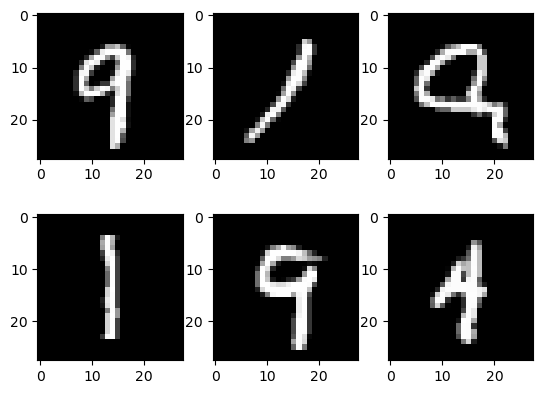

In [3]:
# show some samples from test set

samples = iter(test_loader)
sample_data, sample_targets = next(samples)
print((sample_data[0][0]).size())

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_data[i][0], cmap='gray')
plt.show()

## Model

In [4]:
# resnet style convolutional neural network

class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.downsample = downsample
        self.stride = stride
        
        self.conv1 = nn.Conv2d(in_channels=inplanes, out_channels=planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(planes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x
        
        out = self.relu(self.conv1_bn(self.conv1(x)))
        out = self.conv2_bn(self.conv2(out)) # apply the relu after the skipped connection addition
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out
        
        
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.inplanes = 8
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1_bn = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=3, padding=1)
        
        self.layer1 = self._make_layer(block, 8, layers[0])
        self.layer2 = self._make_layer(block, 16, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 32, layers[2], stride=2)
        
        self.adaptAvgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)
        
        
        
    def _make_layer(self, block, planes, n_blocks, stride=1):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(nn.Conv2d(in_channels=self.inplanes, out_channels=planes, kernel_size=1, stride=stride, bias=False),
                                       nn.BatchNorm2d(planes))
        
        # the first convolutional layer for each block which reduce the size of the features space
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        # the other convolutional layer of the block in which the features dimension and the channels are the same for all the layers
        for _ in range(1, n_blocks):
            layers.append(block(self.inplanes, planes))
        
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.relu(self.conv1_bn(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.adaptAvgPool(x)
        x = x.reshape(x.shape[0], -1) # flatten the out in a single vector
        x = self.fc(x)
        
        return x 

In [5]:
layers = [2, 3, 3]
model = ResNet(BasicBlock, layers, num_classes=10).to(device)
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Conv2d: 1-1                            [64, 8, 14, 14]           392
├─BatchNorm2d: 1-2                       [64, 8, 14, 14]           16
├─ReLU: 1-3                              [64, 8, 14, 14]           --
├─MaxPool2d: 1-4                         [64, 8, 5, 5]             --
├─Sequential: 1-5                        [64, 8, 5, 5]             --
│    └─BasicBlock: 2-1                   [64, 8, 5, 5]             --
│    │    └─Conv2d: 3-1                  [64, 8, 5, 5]             576
│    │    └─BatchNorm2d: 3-2             [64, 8, 5, 5]             16
│    │    └─ReLU: 3-3                    [64, 8, 5, 5]             --
│    │    └─Conv2d: 3-4                  [64, 8, 5, 5]             576
│    │    └─BatchNorm2d: 3-5             [64, 8, 5, 5]             16
│    │    └─ReLU: 3-6                    [64, 8, 5, 5]             --
│    └─Basic

## Training and Validation the Model

In [6]:
# loss and optmizer
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
EPOCHS = 5 #100

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    print('\n')
    val_epoch_loss, val_epoch_acc = test(model, val_loader, criterion)
    
    print('\n')
    print(f"training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}%")
    print(f"validation loss: {val_epoch_loss:.3f}, validation acc: {val_epoch_acc:.3f}%")
    print('-'*50)

[INFO]: Epoch 1 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.372, training acc: 61.169%
validation loss: 0.780, validation acc: 82.100%
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.564, training acc: 87.589%
validation loss: 0.384, validation acc: 90.950%
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.333, training acc: 92.107%
validation loss: 0.262, validation acc: 93.367%
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.247, training acc: 93.813%
validation loss: 0.206, validation acc: 94.600%
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.204, training acc: 94.706%
validation loss: 0.177, validation acc: 95.150%
--------------------------------------------------


In [8]:
"""
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './model.pth')
""";